In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths & Params
DATA_DIR = "data"
MODEL_PATH = "asl_mobilenetv2_best.pth"
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset & Dataloaders
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = full_dataset.classes
NUM_CLASSES = len(class_names)

c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Train / val / test split
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_ds, val_ds, test_ds = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# Model
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Tracking
train_acc_history, val_acc_history = [], []
best_val_acc = 0

c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\acer/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:03<00:00, 4.23MB/s]


In [4]:
# Training Loop
for epoch in range(EPOCHS):
    model.train()
    correct_train, total_train = 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        torch.save(model.state_dict(), MODEL_PATH)
        best_val_acc = val_acc
        print("✅ Saved best model")

Epoch 1/20: 100%|██████████| 53/53 [02:28<00:00,  2.80s/it]


Epoch 1: Train Acc: 0.4676, Val Acc: 0.7917
✅ Saved best model


Epoch 2/20: 100%|██████████| 53/53 [02:44<00:00,  3.11s/it]


Epoch 2: Train Acc: 0.8709, Val Acc: 0.9000
✅ Saved best model


Epoch 3/20: 100%|██████████| 53/53 [02:51<00:00,  3.24s/it]


Epoch 3: Train Acc: 0.9524, Val Acc: 0.9417
✅ Saved best model


Epoch 4/20: 100%|██████████| 53/53 [02:40<00:00,  3.03s/it]


Epoch 4: Train Acc: 0.9881, Val Acc: 0.9583
✅ Saved best model


Epoch 5/20: 100%|██████████| 53/53 [02:29<00:00,  2.82s/it]


Epoch 5: Train Acc: 0.9988, Val Acc: 0.9639
✅ Saved best model


Epoch 6/20: 100%|██████████| 53/53 [02:16<00:00,  2.58s/it]


Epoch 6: Train Acc: 1.0000, Val Acc: 0.9639


Epoch 7/20: 100%|██████████| 53/53 [02:38<00:00,  2.98s/it]


Epoch 7: Train Acc: 1.0000, Val Acc: 0.9583


Epoch 8/20: 100%|██████████| 53/53 [02:44<00:00,  3.10s/it]


Epoch 8: Train Acc: 0.9988, Val Acc: 0.9639


Epoch 9/20: 100%|██████████| 53/53 [02:33<00:00,  2.90s/it]


Epoch 9: Train Acc: 1.0000, Val Acc: 0.9639


Epoch 10/20: 100%|██████████| 53/53 [02:17<00:00,  2.59s/it]


Epoch 10: Train Acc: 1.0000, Val Acc: 0.9694
✅ Saved best model


Epoch 11/20: 100%|██████████| 53/53 [02:29<00:00,  2.81s/it]


Epoch 11: Train Acc: 1.0000, Val Acc: 0.9667


Epoch 12/20: 100%|██████████| 53/53 [02:41<00:00,  3.05s/it]


Epoch 12: Train Acc: 1.0000, Val Acc: 0.9639


Epoch 13/20: 100%|██████████| 53/53 [02:38<00:00,  3.00s/it]


Epoch 13: Train Acc: 1.0000, Val Acc: 0.9667


Epoch 14/20: 100%|██████████| 53/53 [02:26<00:00,  2.76s/it]


Epoch 14: Train Acc: 1.0000, Val Acc: 0.9639


Epoch 15/20: 100%|██████████| 53/53 [02:19<00:00,  2.63s/it]


Epoch 15: Train Acc: 1.0000, Val Acc: 0.9611


Epoch 16/20: 100%|██████████| 53/53 [02:31<00:00,  2.86s/it]


Epoch 16: Train Acc: 1.0000, Val Acc: 0.9694


Epoch 17/20: 100%|██████████| 53/53 [02:38<00:00,  2.99s/it]


Epoch 17: Train Acc: 1.0000, Val Acc: 0.9667


Epoch 18/20: 100%|██████████| 53/53 [02:30<00:00,  2.84s/it]


Epoch 18: Train Acc: 1.0000, Val Acc: 0.9667


Epoch 19/20: 100%|██████████| 53/53 [02:20<00:00,  2.64s/it]


Epoch 19: Train Acc: 1.0000, Val Acc: 0.9667


Epoch 20/20: 100%|██████████| 53/53 [02:24<00:00,  2.72s/it]


Epoch 20: Train Acc: 1.0000, Val Acc: 0.9722
✅ Saved best model



🧾 Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        13
           6       0.90      1.00      0.95         9
           7       1.00      0.93      0.97        15
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00         8
           A       1.00      1.00      1.00         9
           B       1.00      1.00      1.00        17
           C       1.00      1.00      1.00        14
           D       1.00      1.00      1.00        14
           E       1.00      1.00      1.00         6
           F       1.00      1.00      1.00         8
           G       1.00      1.00      1.00         6


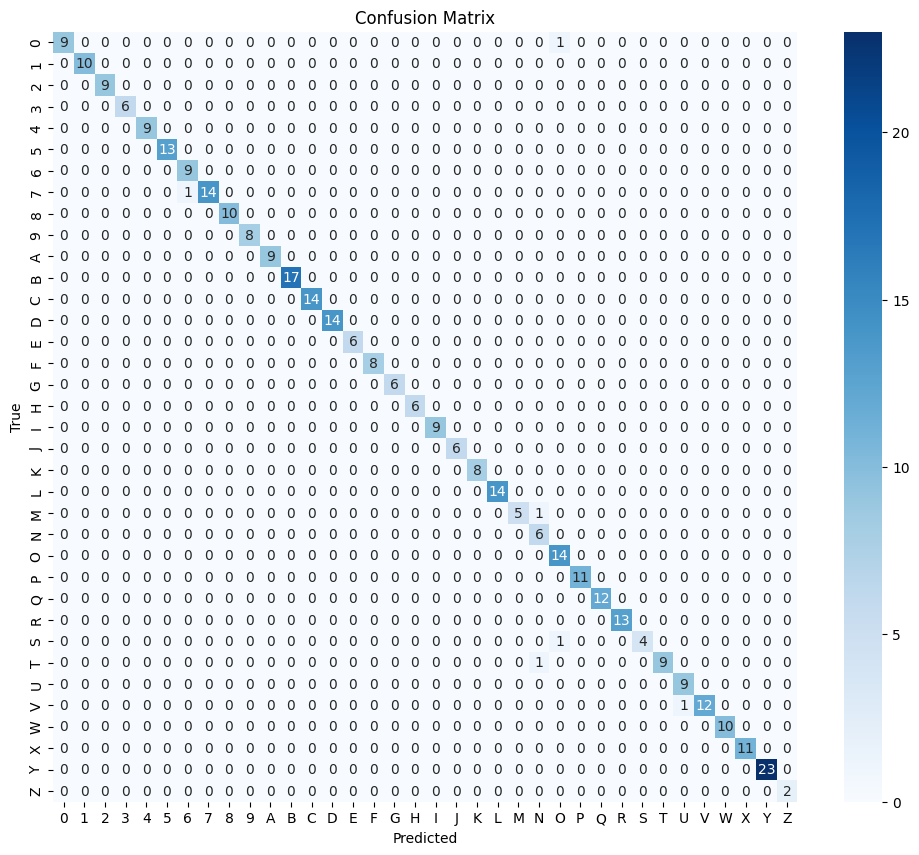


📌 Test Accuracy: 0.9834


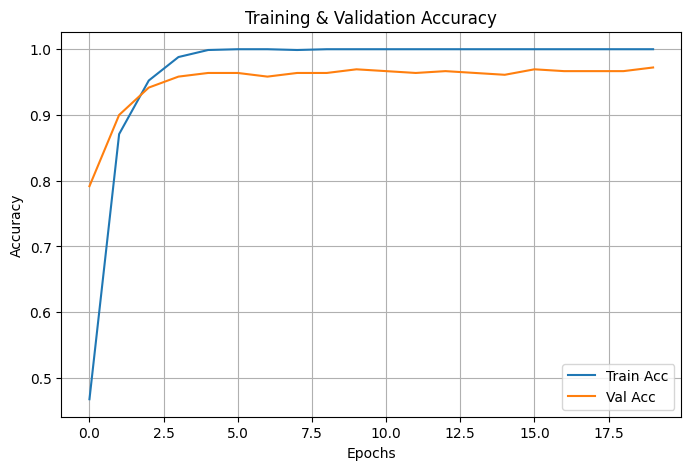

In [5]:
from sklearn.metrics import accuracy_score

# Load Best Model
model.load_state_dict(torch.load(MODEL_PATH))

# 📊 Evaluation on Test Set
model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# ✅ Classification Report
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# ✅ Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ✅ ROC-AUC (if num_classes <= 10)
if NUM_CLASSES <= 10:
    y_true_onehot = np.eye(NUM_CLASSES)[y_true]
    roc_auc = roc_auc_score(y_true_onehot, np.array(y_probs), multi_class='ovr')
    print(f"🔥 ROC-AUC Score: {roc_auc:.4f}")

    # Optional: ROC Curves
    plt.figure(figsize=(10, 6))
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], np.array(y_probs)[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# ✅ Accuracy
test_acc = accuracy_score(y_true, y_pred)
print(f"\n📌 Test Accuracy: {test_acc:.4f}")

# ✅ Plot training vs validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


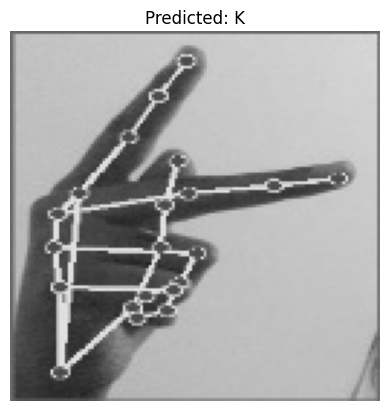

Prediction: K


In [12]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# --- Set up ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "asl_mobilenetv2_best.pth"
NUM_CLASSES = 36  # or whatever yours is
class_names = [  
    '0', '1', '2', '3', '4','5', '6', '7', '8', '9','A', 'B', 'C', 'D', 'E','F', 'G', 'H', 'I', 'J','K', 'L', 'M', 'N', 'O','P', 'Q', 'R', 'S', 'T','U', 'V', 'W', 'X', 'Y','Z'  # fill this with your actual list
]

# --- Load model ---
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval().to(device)

# --- Transform for image ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Predict Function ---
def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    predicted_class = class_names[predicted.item()]

    # Display result
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()

    return predicted_class

# --- Try it ---
img_path = "Image_1742561507.2593908.jpg"  # replace with your image path
print("Prediction:", predict(img_path))
